# Проект: Мэтчинг товаров

**Описание проекта**

Дано: 
Два множества объектов: A и B. Каждый объект в множества описывается какими-то признаками.

Желаемый результат: 
 Для каждого объекта из множества A найти один или несколько объектов из B, которые близки к нему по некоторой заданной метрике.

! A и B могут быть одним и тем же множеством

!! Можем и не найти ни одного соответствия


**Описание данных**

- base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72;

- train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов);

- validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv;

- validation_answer.csv - правильные ответы к предыдущему файлу.

**Задачи**

1. Разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base.

2. Оценить качество алгоритма по метрике accuracy@5.

*деплой: разработать REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.

## Импорт библиотек и загрузка данных

При работе были использованы различные подходы и как следствие различные библиотеки и инструменты, которые не будут задействованы в данной работе. Но удалять их из общего импорта я не решил, так для дальнейших жкспериментов мне это еще пригодится.

In [1]:
!pip install sweetviz
!pip install faiss-cpu
!pip install adjdatatools
!pip install sentence_transformers
#!pip install xgboost

In [2]:
# Импортируем библиотеки
import os
import time
import warnings
from collections import defaultdict
from scipy.spatial import distance

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics.pairwise import paired_distances
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from tqdm.notebook import tqdm
from adjdatatools.preprocessing import AdjustedScaler
import sweetviz as sv
import faiss
#import xgboost

from sentence_transformers import util

import joblib

from IPython.display import IFrame, Image

STATE = 12345

warnings.filterwarnings("ignore")

In [3]:
# Загружаем данные
base = pd.read_csv('/Users/ichekotov/Desktop/data/base.csv', index_col='Id')
train = pd.read_csv('/Users/ichekotov/Desktop/data/train.csv', index_col='Id')
validation = pd.read_csv('/Users/ichekotov/Desktop/data/validation.csv', index_col='Id')
validation_answers = pd.read_csv('/Users/ichekotov/Desktop/data/validation_answer.csv', index_col='Id')

## Основные функции

In [4]:
def L2_distance(X_train: np.ndarray, y_train: np.ndarray, marks: np.ndarray) -> np.ndarray:
    """
    Вычисляет евклидово расстояние между двумя массивами и изменение расстояния при исключении каждого признака.

    Параметры:
    X_train (np.ndarray): Массив признаков обучающего набора.
    y_train (np.ndarray): Массив признаков тестового набора или одного объекта.
    marks (np.ndarray): Массив меток.

    Возвращает:
    np.ndarray: Массив с изменениями расстояний и метками.
    """
    
    assert X_train.shape == y_train.shape,
    assert X_train.shape[0] == marks.size,

    # Вычисляем евклидовы расстояния с помощью векторизации
    dists = np.linalg.norm(X_train - y_train, axis=1)

    # Создаем массив для результатов
    dist = np.zeros((X_train.shape[0], X_train.shape[1] + 2))

    # Заполняем последний столбец метками
    dist[:, -1] = marks

    # Заполняем предпоследний столбец расстояниями
    dist[:, -2] = dists

    # Вычисляем изменение расстояния для каждого признака без цикла
    mask = np.ones(X_train.shape[1], dtype=bool)
    for i in range(X_train.shape[1]):
        mask[i] = False
        reduced_dists = np.linalg.norm(X_train[:, mask] - y_train[:, mask], axis=1)
        mask[i] = True
        
        # Обновляем значения только если общее расстояние не равно нулю
        nonzero_mask = dists != 0
        dist[nonzero_mask, i] = (dists[nonzero_mask] - reduced_dists[nonzero_mask]) / dists[nonzero_mask]

    return dist

In [5]:
def create_index(*, vectors: np.array, nlist: int = 1, nprobe: int = 1) -> faiss.Index:
    """
    Создает и обучает FAISS индекс для быстрого поиска ближайших соседей.

    Параметры:
    vectors (np.array): Numpy массив векторов для индексации.
    nlist (int): Количество списков инвертированного файла (IVF).
    nprobe (int): Количество списков IVF для просмотра при поиске.

    Возвращает:
    faiss.Index: Обученный индекс FAISS.
    """
    
    # Проверка на корректность параметров
    assert nlist >= 1 and nprobe >= 1, "nlist и nprobe должны быть >= 1"
    
    dim = vectors.shape[1]
    
    if nlist > 1:
        # Используем индекс с квантизатором для больших объемов данных
        quantizer = faiss.IndexFlatL2(dim)  # L2 квантизатор для расстояния
        index = faiss.IndexIVFFlat(quantizer, dim, nlist)  # Создаем IVF индекс
        index.train(vectors)  # Обучаем индекс
        index.nprobe = nprobe  # Устанавливаем количество проб для поиска
    else:
        # Используем простой плоский индекс для малого объема данных
        index = faiss.IndexFlatL2(dim)
    
    index.add(vectors)  # Добавляем векторы в индекс
    
    return index

In [6]:
def get_base_id(*, idx_pred: np.ndarray, base_id: np.ndarray) -> np.ndarray:
    """
    Преобразует предсказанные индексы в их соответствующие уникальные ID из базы данных.

    Параметры:
    idx_pred (np.ndarray): Массив предсказанных индексов.
    base_id (np.ndarray): Массив ID, соответствующих базе данных.

    Возвращает:
    np.ndarray: Массив предсказанных ID с уникальными значениями в каждой строке.
    """
    
    # Предварительно создаем массив с типом object для хранения предсказанных ID
    id_pred = np.empty_like(idx_pred, dtype=object)
    
    # Проходим по всем строкам предсказанных индексов
    for row in range(idx_pred.shape[0]):
        # Получаем уникальные индексы в текущей строке без сортировки
        unique_indices = np.unique(idx_pred[row], return_index=False)
        unique_count = len(unique_indices)
        
        # Присваиваем уникальные ID на основе уникальных индексов
        id_pred[row, :unique_count] = base_id[unique_indices]
        
    return id_pred

In [7]:
def get_search_depthwise(*, id_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    """
    Создает матрицу с глубиной поиска, где каждый элемент представляет собой 1 или 0,
    в зависимости от того, соответствует ли предсказанный ID истинному значению.

    Параметры:
    id_pred (np.ndarray): Массив предсказанных ID.
    y_true (np.ndarray): Массив истинных значений.

    Возвращает:
    np.ndarray: Массив с 1 и 0, представляющий глубину поиска.
    """
    
    # Инициализация массива для хранения результатов классификации
    depth_pred = np.zeros(id_pred.shape, dtype=int)
    
    # Проходим по всем строкам предсказанных ID
    for row in range(id_pred.shape[0]):
        # Определяем количество уникальных ненулевых ID в текущей строке
        valid_indices = ~pd.isnull(id_pred[row])
        uniq_idx_cnt = np.sum(valid_indices)
        
        # Сравниваем предсказанные ID с истинным значением и присваиваем 1 или 0
        depth_pred[row, :uniq_idx_cnt] = (id_pred[row, :uniq_idx_cnt] == y_true[row]).astype(int)
    
    return depth_pred

In [8]:
def scale_and_describe(data, scaler):
    """Функция для нормализации данных и вывода их описательной статистики."""
    
    # Нормализация данных
    scaled_data = scaler.transform(data)
    
    # Преобразование в DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
    
    # Вывод описательной статистики
    display(scaled_df.describe())
    
    return scaled_df

## Изучение данных

                                             |             | [  0%]   00:00 -> (? left)

KeyboardInterrupt: 

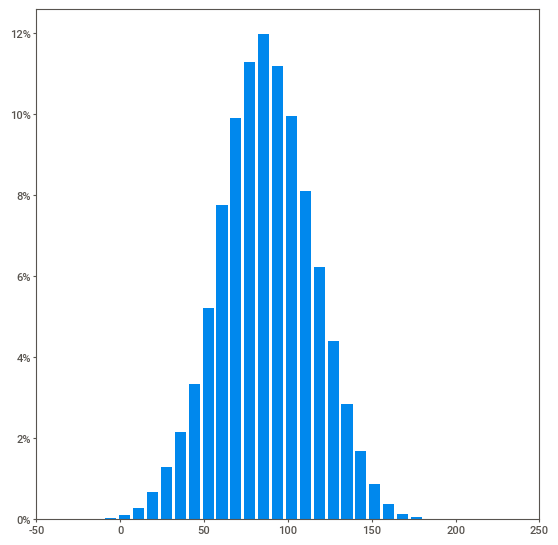

In [9]:
# Cоздание аналитических отчетов
base_report = sv.analyze(base)
train_report = sv.analyze(train)
validation_report = sv.analyze(validation)
validation_answers_report = sv.analyze(validation_answers)

### Base

In [ ]:
base_report.show_notebook()

### Train

In [ ]:
train_report.show_notebook()

### Valid

In [ ]:
validation_report.show_notebook()

### Answer

In [ ]:
validation_answers_report.show_notebook()

### Основные выводы

- В основном все признаки распределены нормально;
- Аномальными признаками являются № 6, 21, 25, 33, 44, 59, 65, 70.

## Нормализация данных

In [9]:
# Разделим запросы и ответы экспертов
target = train['Target']
train.drop('Target', axis=1, inplace=True)

In [10]:
scaler = AdjustedScaler()

In [11]:
# Обучим на base
scaler.fit(base)

In [12]:
# Нормализация базового набора товаров
base = scaler.transform(base)

In [13]:
# Выведем результат нормализации
base = pd.DataFrame(base)
base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,1.498951e-05,1.526674e-03,-3.854259e-03,1.336623e-03,-2.259294e-03,-4.439291e-04,3.326787e-02,-1.313616e-03,-6.175078e-03,2.825030e-03,...,-3.336402e-03,-1.013278e-02,-3.852106e-03,9.466092e-04,-2.352200e-03,4.447394e-04,8.933930e-05,-4.136419e-03,2.314199e-01,3.602215e-03
std,1.841201e-01,1.838741e-01,1.948398e-01,1.870341e-01,1.882087e-01,1.811426e-01,3.014696e-01,1.866508e-01,1.886847e-01,1.895319e-01,...,1.900267e-01,2.064622e-01,1.939372e-01,2.887462e-01,1.872036e-01,1.916855e-01,1.868477e-01,1.913565e-01,3.241872e-01,1.878152e-01
min,-8.376112e-01,-8.149356e-01,-9.898262e-01,-8.095024e-01,-8.830374e-01,-8.938620e-01,-4.097961e-01,-9.378539e-01,-9.125105e-01,-8.747562e-01,...,-8.864681e-01,-8.807317e-01,-9.404238e-01,-5.002191e-01,-8.526865e-01,-8.886126e-01,-8.483655e-01,-9.063937e-01,-1.879671e-01,-8.016293e-01
25%,-1.245200e-01,-1.236296e-01,-1.298349e-01,-1.237316e-01,-1.273661e-01,-1.250479e-01,-2.298631e-01,-1.250597e-01,-1.308619e-01,-1.227554e-01,...,-1.265066e-01,-1.266990e-01,-1.260759e-01,-2.484073e-01,-1.266555e-01,-1.244580e-01,-1.253496e-01,-1.295680e-01,0.000000e+00,-1.218020e-01
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.255629e-01,1.273661e-01,1.220096e-01,1.267561e-01,1.238585e-01,1.251992e-01,2.946758e-01,1.253131e-01,1.210645e-01,1.286173e-01,...,1.245025e-01,1.247182e-01,1.252960e-01,2.504887e-01,1.244445e-01,1.258638e-01,1.247156e-01,1.222496e-01,4.783747e-01,1.299145e-01
max,7.970008e-01,8.128829e-01,1.032681e+00,8.991486e-01,8.437923e-01,8.401495e-01,5.902039e-01,9.313399e-01,8.421482e-01,8.943908e-01,...,8.651552e-01,8.537856e-01,8.388800e-01,4.997809e-01,8.108296e-01,1.009589e+00,8.060656e-01,8.917715e-01,9.868579e-01,7.898294e-01


In [14]:
# Нормализация тренировочного набора товаров
train = scaler.transform(train)

In [15]:
# Выведем результат нормализации
train = pd.DataFrame(train)
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.006678,-0.013906,0.000754,0.006203,-0.000416,-0.008075,-0.020434,0.001241,-0.024472,0.007714,...,-0.016581,0.015604,0.008251,0.000510,-0.001542,-0.001341,-0.004623,-0.007543,0.306767,0.000388
std,0.190870,0.183958,0.197258,0.192595,0.193702,0.184567,0.309640,0.191792,0.192721,0.190950,...,0.191396,0.181243,0.192954,0.289121,0.188708,0.192131,0.189461,0.195035,0.341471,0.185418
min,-0.740057,-0.727549,-0.913279,-0.721287,-0.833046,-0.726472,-0.409796,-0.870197,-0.862695,-0.781462,...,-0.820912,-0.682544,-0.770750,-0.500207,-0.733647,-0.786810,-0.782490,-0.844271,-0.187917,-0.725850
25%,-0.126323,-0.138281,-0.129507,-0.124895,-0.131563,-0.134393,-0.351054,-0.124799,-0.154888,-0.120468,...,-0.143608,-0.106785,-0.117372,-0.249705,-0.128740,-0.130098,-0.131716,-0.139485,0.000000,-0.125456
50%,0.007085,-0.014332,0.004975,0.006686,0.001572,-0.009268,-0.099474,0.004285,-0.023888,0.007253,...,-0.014797,0.014269,0.011291,0.000717,-0.000102,0.000086,-0.006243,-0.007119,0.223460,-0.000490
75%,0.139808,0.109219,0.131651,0.136651,0.129489,0.117111,0.245350,0.131072,0.108339,0.135914,...,0.112280,0.137264,0.138954,0.251491,0.127739,0.126508,0.120431,0.124407,0.603416,0.126434
max,0.745738,0.775043,0.867109,0.810773,0.769477,0.795442,0.590196,0.777127,0.755912,0.792272,...,0.787534,0.793028,0.780300,0.499772,0.715126,0.841930,0.746043,0.774789,0.986856,0.786314


In [16]:
# Нормализация набора товаров для валидации модели
validation = scaler.transform(validation)

In [17]:
# Выведем результат нормализации
validation = pd.DataFrame(validation)
validation.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.006874,-0.013706,-0.000130,0.006192,-0.000966,-0.008681,-0.021302,0.002295,-0.024180,0.007364,...,-0.016479,0.014751,0.007696,0.001666,-0.002637,-0.000574,-0.005530,-0.007478,0.307023,0.000790
std,0.190674,0.184008,0.197397,0.193167,0.193908,0.183261,0.309890,0.193225,0.193103,0.191153,...,0.191494,0.181740,0.194017,0.287999,0.189377,0.191899,0.189014,0.194229,0.341223,0.185767
min,-0.770185,-0.710821,-0.876170,-0.690596,-0.784020,-0.673404,-0.409785,-0.832486,-0.821515,-0.762372,...,-0.852689,-0.721759,-0.863892,-0.500217,-0.763540,-0.810801,-0.764057,-0.820123,-0.187961,-0.725850
25%,-0.125750,-0.139074,-0.130447,-0.126608,-0.133076,-0.134109,-0.353365,-0.123848,-0.155391,-0.121156,...,-0.144766,-0.108291,-0.118245,-0.245838,-0.130232,-0.129123,-0.132297,-0.139941,0.000000,-0.124919
50%,0.006914,-0.014145,0.002954,0.006564,0.000351,-0.010649,-0.101788,0.003875,-0.024630,0.007607,...,-0.015842,0.012144,0.012001,0.002747,-0.001451,0.000320,-0.008460,-0.006718,0.224951,-0.000351
75%,0.139132,0.109690,0.131388,0.138145,0.130069,0.116073,0.243734,0.131648,0.108255,0.135853,...,0.113639,0.137041,0.139126,0.250887,0.125899,0.127248,0.119967,0.124218,0.602312,0.127354
max,0.744574,0.719063,0.901159,0.842533,0.772326,0.785196,0.590203,0.751831,0.829127,0.792272,...,0.747959,0.759850,0.792975,0.499770,0.778842,0.789267,0.703614,0.773332,0.986830,0.721712


In [18]:
## Нормализация и вывод статистики для базового набора товаров
#base_scaled = scale_and_describe(base, scaler)

In [19]:
## Нормализация и вывод статистики для тренировочного набора товаров
#train_scaled = scale_and_describe(train, scaler)

In [20]:
## Нормализация и вывод статистики для набора товаров для валидации модели
#validation_scaled = scale_and_describe(validation, scaler)

In [21]:
# Приведем все к единообразию
X_train = train.copy()
y_train = target.copy()
X_valid = validation.copy()

### Основные выводы

- мы нормализовали (теперь диапазон значений от -1 до 1) и подготовили данные к адльнейшей работе.


## FAISS и accuracy@5

In [22]:
# Параметры для индекса
nlist = 100
nprobe = 5
top_n = 5

# Создание индекса
index = create_index(vectors=base.values, nlist=nlist, nprobe=nprobe)

# Запуск таймера
start_time = time.time()

# Поиск ближайших соседей
distances, indices = index.search(X_train.values, top_n)

# Получение предсказанных ID
predicted_ids = get_base_id(idx_pred=indices, base_id=base.index)

# Расчет точности на первом соседе
accuracy_at_1 = (predicted_ids[:, 0] == y_train).mean()
print(f'Accuracy@1: {accuracy_at_1:.5f}')

# Расчет точности на top_n соседях
is_correct_prediction = [y_train.iloc[i] in predicted_ids[i] for i in range(len(y_train))]
accuracy_at_top_n = sum(is_correct_prediction) / len(y_train)
print(f'Accuracy@{top_n}: {accuracy_at_top_n:.5f}')

# Остановка таймера и вывод времени выполнения
elapsed_time = time.time() - start_time
print(f'Затрачено времени: {elapsed_time:.2f} сек.')

Accuracy@1: 0.14107
Accuracy@5: 0.43309
Затрачено времени: 111.42 сек.


In [25]:
# Получение глубины поиска для каждого предсказанного ID
search_depths = get_search_depthwise(id_pred=predicted_ids, y_true=y_train)

# Вычисление L2 расстояния
train_distances = L2_distance(X_train.values, base.loc[y_train.values].values, search_depths[:, 0])

# Вычисление среднего расстояния и вывод результата
average_distance = round(np.mean(train_distances[:, -2]), 3)
print(f'Среднее расстояние между векторами из train: {average_distance:.2f}')

Среднее расстояние между векторами из train: 1.14


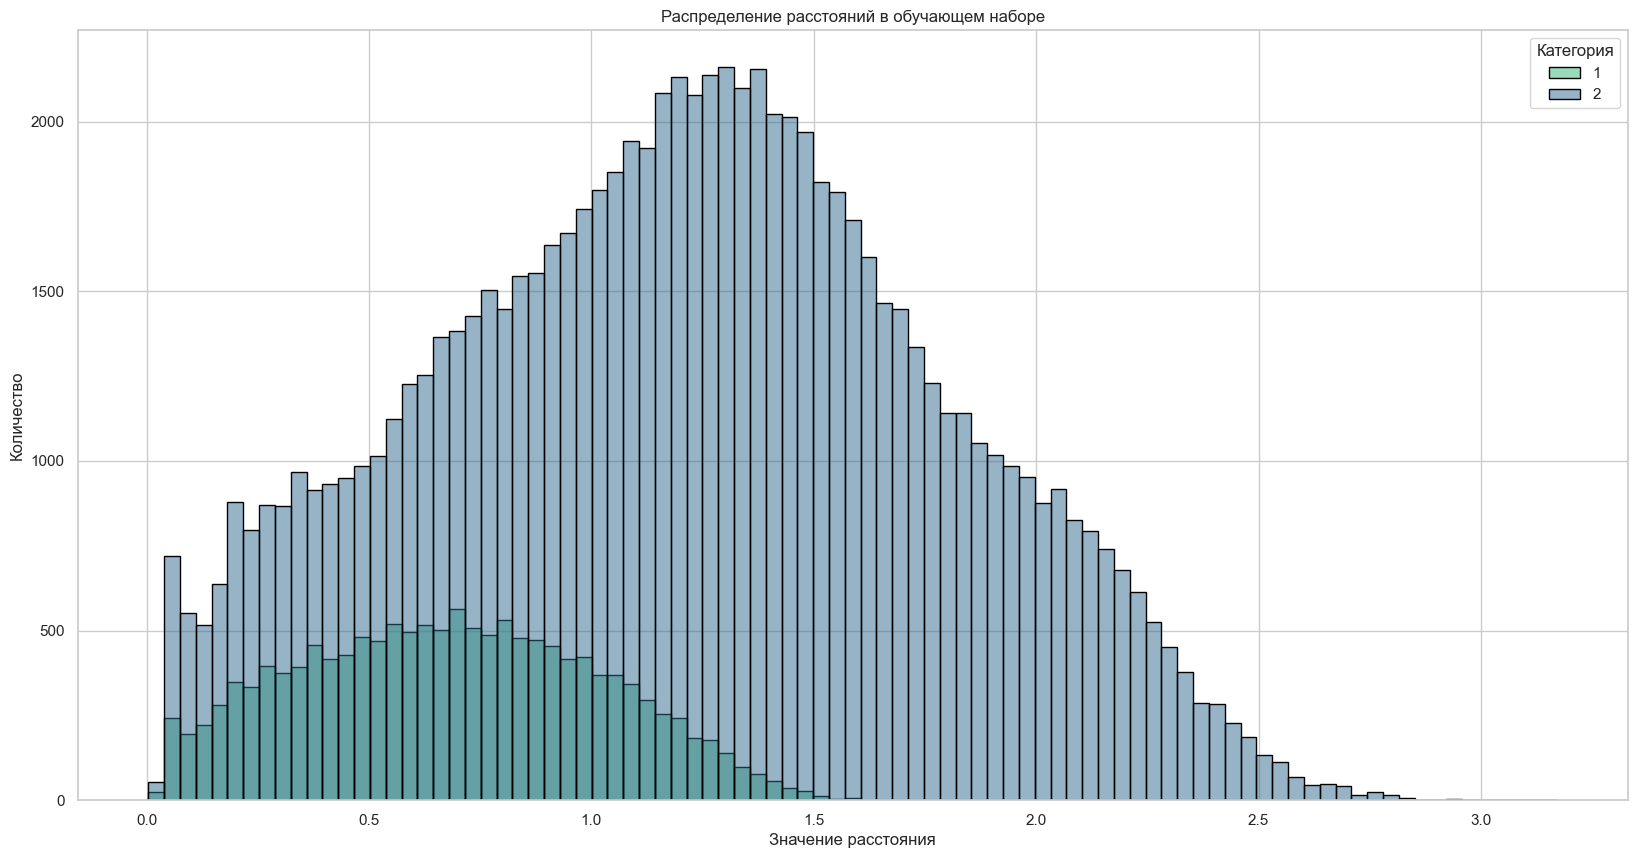

In [26]:
# Создание графика
sns.set(style="whitegrid")

plt.figure(figsize=(20, 10))

x_data = train_distances[:, -2]
hue_data = train_distances[:, -1]

sns.histplot(data=train_distances, x=x_data, hue=hue_data, palette='viridis', edgecolor='black')

plt.xlabel('Значение расстояния')
plt.ylabel('Количество')
plt.title('Распределение расстояний в обучающем наборе')
plt.legend(title='Категория', labels=['1', '2'])
plt.show()

In [27]:
# Поработаем наконец с аномальными признаками
not_normalized_columns = ['6', '21', '25', '33', '44', '59', '65', '70']

# Создание списка колонок для нормализации путем исключения тех, что в not_normalized_columns
normalized_columns = [column for column in X_train.columns if column not in not_normalized_columns]

In [28]:
# Параметры для индекса
nlist = 100
nprobe = 5
top_n = 5

# Создание индекса
index = create_index(vectors=base[normalized_columns].values, nlist=nlist, nprobe=nprobe)

# Запуск таймера
start_time = time.time()

# Поиск ближайших соседей
distances, indices = index.search(X_train[normalized_columns].values, top_n)

# Получение предсказанных ID
predicted_ids = get_base_id(idx_pred=indices, base_id=base.index)

# Расчет точности на первом соседе
accuracy_at_1 = (predicted_ids[:, 0] == y_train).mean()
print(f'Accuracy@1: {accuracy_at_1:.5f}')

# Расчет точности на top_n соседях
is_correct_prediction = [y_train.iloc[i] in predicted_ids[i] for i in range(len(y_train))]
accuracy_at_top_n = sum(is_correct_prediction) / len(y_train)
print(f'Accuracy@{top_n}: {accuracy_at_top_n:.5f}')

# Остановка таймера и вывод времени выполнения
elapsed_time = time.time() - start_time
print(f'Затрачено времени: {elapsed_time:.2f} сек.')

Accuracy@1: 0.22366
Accuracy@5: 0.69717
Затрачено времени: 80.35 сек.


In [29]:
# Получение глубины поиска для каждого предсказанного ID
search_depths = get_search_depthwise(id_pred=predicted_ids, y_true=y_train)

# Вычисление L2 расстояния
train_distances = L2_distance(X_train[normalized_columns].values, base.loc[y_train.values, normalized_columns].values, search_depths[:, 0])

# Вычисление среднего расстояния и вывод результата
average_distance = round(np.mean(train_distances[:, -2]), 3)
print(f'Среднее расстояние между векторами из train: {average_distance:.2f}')

Среднее расстояние между векторами из train: 0.59


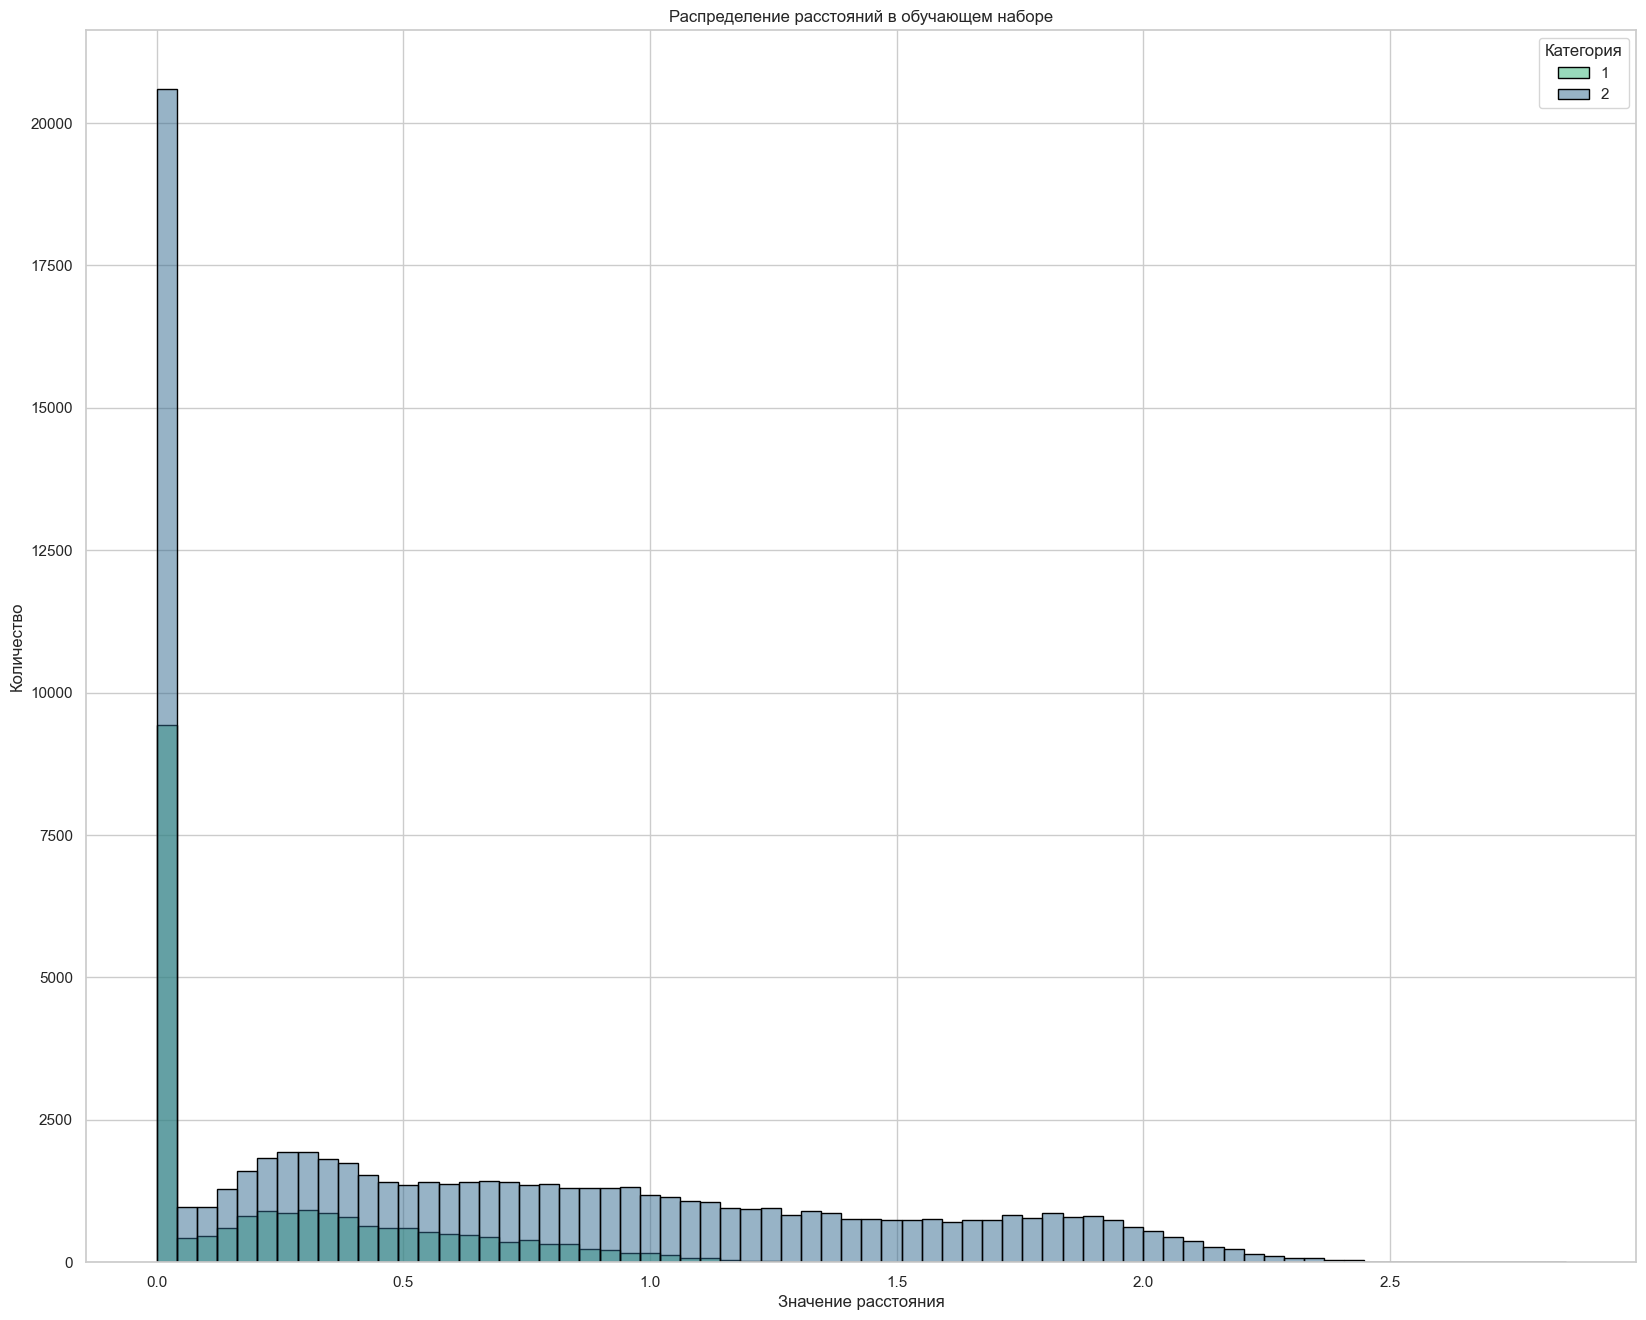

In [30]:
# Создание графика
sns.set(style="whitegrid")

plt.figure(figsize=(20, 16))

x_data = train_distances[:, -2]
hue_data = train_distances[:, -1]

sns.histplot(data=train_distances, x=x_data, hue=hue_data, palette='viridis', edgecolor='black')

plt.xlabel('Значение расстояния')
plt.ylabel('Количество')
plt.title('Распределение расстояний в обучающем наборе')
plt.legend(title='Категория', labels=['1', '2'])
plt.show()

### Основные выводы

- Работа с аномальными признаками, обнаруженными при изучении данных улучшило accuracy@5 и время работы с 0.43309 и 111.42 сек. до 0.69717 и 80.35 сек.;
- В то же время среднее расстояние уменьшилось с 1.14 до 0.59.


## Эксперименты

В данном разделе хотелось попробовать улучшить полученные результаты путем работы в основном с аномальными признаками.

In [31]:
top_n = 100
single_feature_accuracy = pd.DataFrame(columns=['Accuracy@1', 'Accuracy@5', 'Accuracy@10', 'Accuracy@100'], index=base.columns)

for col in base.columns:
        # Очистка переменных перед каждым использованием
    try:
        del index, distances, indices, coord_pred, depth_pred, id_pred
    except NameError:
        pass  # Переменные не были определены, ничего не делаем

    index = create_index(vectors=base[[col]].values, nlist=100, nprobe=2)
    distances, indices = index.search(X_train[[col]].values, top_n)
    id_pred = get_base_id(idx_pred=indices, base_id=base.index)
    depth_pred = get_search_depthwise(id_pred=id_pred, y_true=y_train)

        # Расчет Accuracy
    accuracy_at_1 = (depth_pred[:, 0] == 1).mean()
    accuracy_at_5 = (depth_pred[:, :5] == 1).any(axis=1).mean()
    accuracy_at_10 = (depth_pred[:, :10] == 1).any(axis=1).mean()
    accuracy_at_100 = (depth_pred[:, :100] == 1).any(axis=1).mean()

    single_feature_accuracy.loc[col] = [accuracy_at_1, accuracy_at_5 * 5, accuracy_at_10 * 10, accuracy_at_100 * top_n]
    print(f'{col}: Accuracy@1 = {accuracy_at_1:.3f}, Accuracy@5 = {accuracy_at_5 * 5:.3f}, Accuracy@10 = {accuracy_at_10 * 10:.3f}, Accuracy@{top_n} = {accuracy_at_100 * top_n:.3f}')

0: Accuracy@1 = 0.009, Accuracy@5 = 0.215, Accuracy@10 = 0.761, Accuracy@100 = 24.144
1: Accuracy@1 = 0.010, Accuracy@5 = 0.213, Accuracy@10 = 0.752, Accuracy@100 = 24.185
2: Accuracy@1 = 0.010, Accuracy@5 = 0.214, Accuracy@10 = 0.762, Accuracy@100 = 24.079
3: Accuracy@1 = 0.010, Accuracy@5 = 0.215, Accuracy@10 = 0.766, Accuracy@100 = 24.241
4: Accuracy@1 = 0.009, Accuracy@5 = 0.215, Accuracy@10 = 0.763, Accuracy@100 = 24.146
5: Accuracy@1 = 0.010, Accuracy@5 = 0.213, Accuracy@10 = 0.757, Accuracy@100 = 24.130
6: Accuracy@1 = 0.011, Accuracy@5 = 0.257, Accuracy@10 = 0.989, Accuracy@100 = 45.900
7: Accuracy@1 = 0.009, Accuracy@5 = 0.211, Accuracy@10 = 0.761, Accuracy@100 = 24.081
8: Accuracy@1 = 0.010, Accuracy@5 = 0.213, Accuracy@10 = 0.757, Accuracy@100 = 24.037
9: Accuracy@1 = 0.010, Accuracy@5 = 0.213, Accuracy@10 = 0.756, Accuracy@100 = 24.175
10: Accuracy@1 = 0.010, Accuracy@5 = 0.213, Accuracy@10 = 0.755, Accuracy@100 = 24.151
11: Accuracy@1 = 0.010, Accuracy@5 = 0.212, Accuracy@

In [32]:
display(single_feature_accuracy.head(10))
print(f"Avg. Accuracy@1: {round(single_feature_accuracy['Accuracy@1'].mean(), 5)}")

,Accuracy@1,Accuracy@5,Accuracy@10,Accuracy@100
0,0.00945,0.2155,0.7609,24.144
1,0.00959,0.2127,0.7525,24.185
2,0.00955,0.21375,0.7616,24.079
3,0.00966,0.2153,0.766,24.241
4,0.00936,0.2148,0.7629,24.146
5,0.00954,0.21325,0.7568,24.13
6,0.01061,0.2572,0.9892,45.9
7,0.00912,0.21065,0.7607,24.081
8,0.00959,0.2131,0.7569,24.037
9,0.00971,0.21265,0.7559,24.175


Avg. Accuracy@1: 0.00926


In [33]:
# Преобразование строковых значений в целые для индексации и сортировка результатов
subset_cols = ['21', '25', '33', '59']
display(single_feature_accuracy.loc[subset_cols].sort_values(by='Accuracy@1', ascending=False))

,Accuracy@1,Accuracy@5,Accuracy@10,Accuracy@100
21,0.00207,0.04795,0.181,6.623
25,0.00097,0.02365,0.0944,3.535
33,0.0,0.0,0.0,0.001
59,0.0,0.0,0.0,0.001


In [34]:
index_cols = [['21'], ['25'], ['33'], ['59']]
map_idxs = [(idx_num + 1, col) for idx_num, col in enumerate(index_cols)]
for index in map_idxs:
    print(index)

(1, ['21'])
(2, ['25'])
(3, ['33'])
(4, ['59'])


In [35]:
top_n = 1
model_target = pd.Series(index=X_train.index, data=np.zeros(X_train.shape[0]), dtype=int)

# Запуск таймера
start_time = time.time()

for label, index_cols in map_idxs:
    mask = model_target == 0  # Маска для объектов без соответствия
    index = create_index(vectors=base[index_cols].values, nlist=100, nprobe=5)
    query_vectors = X_train.loc[mask, index_cols].values
    _, I = index.search(query_vectors, top_n)
    base_ids_pred = get_base_id(idx_pred=I, base_id=base.index)
    
    # Сравниваем предсказанные ID с фактическими метками
    correct_predictions = base_ids_pred.flatten() == y_train[mask].values
    marked_predictions = correct_predictions.astype(int) * label
    
    # Обновляем model_target только для объектов, где маска True
    model_target.loc[mask] = marked_predictions

# Остановка таймера и вывод времени выполнения
elapsed_time = time.time() - start_time
print(f'Затрачено времени: {elapsed_time:.2f} сек.')

Затрачено времени: 155.37 сек.


In [36]:
# Получаем уникальные значения и их количество с помощью value_counts()
value_counts = model_target.value_counts().sort_index()

# Выводим результат
print(value_counts)

0    93994
1     3654
2     2352
dtype: int64


In [37]:
# Начинаем отсчет времени
start_time = time.time()

# Создаем экземпляр классификатора
model = LogisticRegression(random_state=STATE)

# Выполняем кросс-валидацию
y_pred_cv = cross_val_predict(model, X_train, model_target, cv=2, n_jobs=-1)
score = accuracy_score(model_target, y_pred_cv)

# Заканчиваем отсчет времени
end_time = time.time()

# Выводим точность и затраченное время
print(f'Точность: {score * 100:.2f}%')
print(f'Затрачено времени: {end_time - start_time:.2f} секунд')

Точность: 93.98%
Затрачено времени: 5.54 секунд


In [38]:
# Используем zip для объединения значений и счетчиков и цикл for для вывода
values, counts = np.unique(y_pred_cv, return_counts=True)
for value, count in zip(values, counts):
    print(f'Значение: {value}, Число: {count}')

Значение: 0, Число: 99882
Значение: 1, Число: 14
Значение: 2, Число: 104


In [39]:
# Разделение данных на обучающую и тестовую выборки
model_train, model_test, target_train, target_test = train_test_split(
    X_train, model_target, test_size=0.2, random_state=STATE
)

# Обучение классификатора
model.fit(model_train, target_train)

# Прогнозирование меток классов для тестовых данных
y_pred = model.predict(model_test)

# Вычисление точности предсказания и вывод результата
accuracy = accuracy_score(target_test, y_pred)
print(f'Точность: {accuracy * 100:.2f}%')

Точность: 93.95%


In [41]:
top_n = 5
id_pred = np.empty((X_train.shape[0], top_n), dtype = object)

# Запуск таймера
start_time = time.time()

for idx in np.unique(y_pred_cv):
    if idx == 0:
        cols = normalized_columns
    else:
        cols = map_idxs[idx - 1][1]
    index = create_index(vectors = base[cols].values, nlist = 100, nprobe = 5)
    mask = (y_pred_cv == idx)
    _, I = index.search(X_train.loc[mask, cols].values, top_n)
    id_pred[mask] = get_base_id(idx_pred = I, base_id = base.index)
    
accuracy_at_1 = (id_pred[:, 0] == y_train).mean()
print(f'Accuracy@1: {round(accuracy_at_1, 5)}')

correct_predictions = [y_train.iloc[i] in id_pred[i] for i in range(len(y_train))]
accuracy_at_top_n = sum(correct_predictions) / len(y_train)
print(f'Accuracy@{top_n}: {round(accuracy_at_top_n, 5)}')

# Остановка таймера и вывод времени выполнения
elapsed_time = time.time() - start_time
print(f'Затрачено времени: {elapsed_time:.2f} сек.')

Accuracy@1: 0.22355
Accuracy@5: 0.69671
Затрачено времени: 93.24 сек.


### Основные выводы

Экспермент отчасти успешен :) accuracy@5 слегка увеличилась, но время также выросло. Особо смысла такие манипуляции не имеют, но оставим так. Не сильно хуже и не особо лучше.

## Итоги

In [42]:
model = LogisticRegression(random_state=STATE)
model.fit(X_train, model_target)

LogisticRegression(random_state=12345)

In [43]:
top_n = 5
y_pred_valid = model.predict(X_valid)
id_pred_valid = np.empty((X_valid.shape[0], top_n), dtype = object)

# Запуск таймера
start_time = time.time()

for idx in np.unique(y_pred_valid):
    if idx == 0:
        cols = normalized_columns
    else:
        cols = map_idxs[idx - 1][1]
    index = create_index(vectors = base[cols].values, nlist = 100, nprobe = 5)
    mask = (y_pred_valid == idx)
    _, I = index.search(X_valid.loc[mask, cols].values, top_n)
    id_pred_valid[mask] = get_base_id(idx_pred = I, base_id = base.index)

# Остановка таймера и вывод времени выполнения
elapsed_time = time.time() - start_time
print(f'Затрачено времени: {elapsed_time:.2f} сек.')

Затрачено времени: 91.37 сек.


In [44]:
# Преобразуем двумерный массив id_pred_valid в список строк, где каждая строка содержит ID, разделенные пробелом.
joined_predictions = [' '.join(row) for row in id_pred_valid]

# Создаем новый DataFrame сразу с нужными значениями.
validation_answers = pd.DataFrame({'Predicted': joined_predictions}, index=X_valid.index)

# Сброс индекса, если это необходимо (зависит от того, нужен ли индекс в дальнейшем).
validation_answers.reset_index(inplace=True)

# Отображаем первые несколько строк DataFrame.
display(validation_answers.head())

,Id,Predicted
0,100000-query,508555-base 1542803-base 2760762-base 3209652-...
1,100001-query,11853-base 163485-base 1000521-base 2666508-ba...
2,100002-query,25113-base 153272-base 472256-base 496010-base...
3,100003-query,1274091-base 1831175-base 2345993-base 3168654...
4,100004-query,75484-base 1217188-base 1656711-base 2366033-b...


## Итоговый вывод

В итоге была проделана следующая работа:

- Данные загружены и изучены;
- Проведена нормализация данных;
- Улучшены показатели accuracy@5 и времени работы;
- Проведен эксперимент (не сильно успешный, но это тоже результат;
- Сопоставлены полученные результаты с данными ответами.

Можно заключить, что в результате данной работы наилучшими значениями accuracy@5 и времени работы являются:

- Accuracy@5: 0.69671
- Время: 93.24 сек.

В качестве рекоммендаций хотелось бы добавить:

- Поробовать иначе поэксперементировать с данными;
- Попробовать иные модели (в ходе данной работы использовались разные, но их работа (особенно с использованием многих гиперпараметров вызывала слишком долгое ожидание...).